In [ ]:
import os
print(os.getcwd()) # You should be running this from the GFlowNetsA directory, unless using Pycharm where it works just fine
import numpy as np
import torch
import matplotlib.pyplot as plt
try:
    from GraphClustering import GraphNet
    from GraphClustering.Core.Core import allPermutations
    # print("All my friends hate hate Core GraphNet")
    # from GraphClustering.Network.Network import GraphNet # This worries me. There is an outdated version of Graphnet in Core. 
except: # Do not change this if it is unnecessary for you. Directly picking the cwd for jupyter notebooks can be a massive hassle in VSCode.
    print("Previous import statement didn't work. Changing cwd to parent directory.") # 
    for _ in range(4):
        print("Stepping one directory up.")
        try:
            os.chdir("..")
            print(os.getcwd())
            from GraphClustering import GraphNet
            from GraphClustering.Core.Core import allPermutations
            print("Successful import.")
            break
        except:
            pass
from GraphClustering import IRM_graph, clusterIndex
from GraphClustering import Cmatrix_to_array, torch_posterior


C:\Users\toell\OneDrive\Documents\GitHub\GFlowNetsA\GraphClustering\Network


In [10]:
# I could just install nbimporter to import this function. Now in Core
# def allPermutations(n):
#     """
#     Return a list of all possible permutations of clustering
#     lists for a graph with n nodes
#     :param n: int
#     :return: numpy array
#     """
#     perm = [[[1]]]
#     for i in range(n-1):
#         perm.append([])
#         for partial in perm[i]:
#             for j in range(1, max(partial) + 2):
#                 perm[i + 1].append(partial + [j])
#
#     return np.array(perm[-1])-1

tensor([0., 0., 1.])


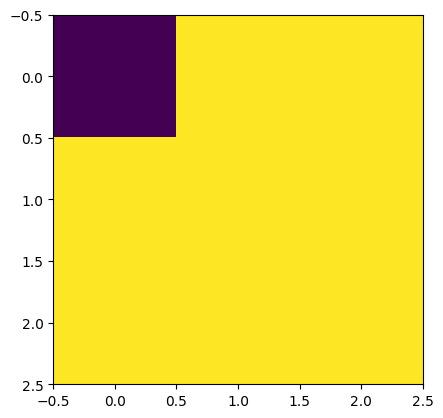

In [11]:
# Making the graph, and outputting cluster indexes.
N =  3
a, b, alpha = 0.5, 0.5, 3
log = True
adjacency_matrix, clusters = IRM_graph(alpha = alpha, a = a, b = b, N = N)
cluster_idxs = clusterIndex(clusters)
clusters = len(clusters)
plt.imshow(adjacency_matrix)
print(cluster_idxs)

net = GraphNet(n_nodes=adjacency_matrix.size()[0], a = a, b = b, alpha = alpha)

tensor([1., 2., 2.])


C:\Users\toell\AppData\Local\Temp\ipykernel_34508\3666193341.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clustering_matrix = net.get_clustering_matrix(torch.tensor(cluster_idxs+1), torch.tensor(clusters))


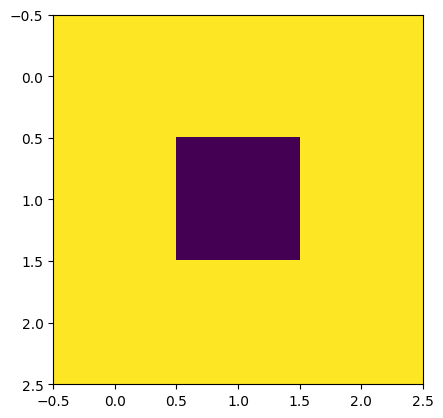

tensor([1., 2., 2.])


In [12]:
idxs = torch.randperm(N, dtype=torch.int64)
A_random = adjacency_matrix[idxs][:, idxs]

# print(torch.tensor(cluster_idxs))
# print(torch.tensor(clusters))
clustering_matrix = net.get_clustering_matrix(torch.tensor(cluster_idxs+1), torch.tensor(clusters))
# plt.figure()
# plt.imshow(clustering_matrix)
# plt.show()
cluster_random, cluster_num = net.get_clustering_list(clustering_matrix[idxs][:, idxs])
print(cluster_random)

plt.figure()
plt.imshow(A_random)
plt.show()
print(cluster_random)

In [13]:
# Computing posteriors for all clusters.
clusters_all = allPermutations(N)
Bell = len(clusters_all)
clusters_all_post = np.zeros(Bell)
for i, cluster in enumerate(clusters_all):
    posterior = (torch_posterior(adjacency_matrix, cluster, a=torch.tensor(a), b=torch.tensor(b), alpha = torch.tensor(alpha), log=True))
    clusters_all_post[i] = posterior

[-2.86789942 -4.17723227 -4.17723227 -4.17723227 -5.96899176]
[-0.61788491 -1.92721776 -1.92721776 -1.92721776 -3.71897725]
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [0 1 2]]


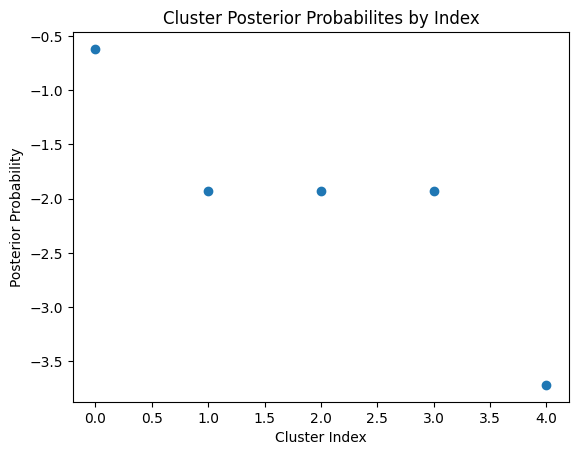

[[0 1 2]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [0 0 0]]


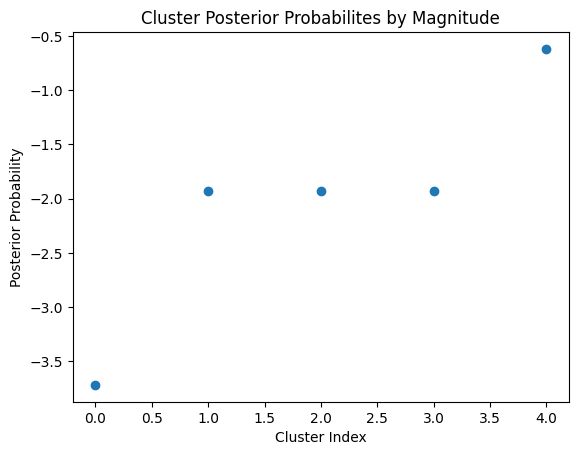

In [14]:

print(clusters_all_post)
# cluster_post = np.exp(clusters_all_post)/np.sum(np.exp(clusters_all_post)) # Numpy can handle -np.inf. This might stop working when many of the probabilities underflow.
from scipy.special import logsumexp
cluster_post = clusters_all_post - logsumexp(clusters_all_post) # Normalize them into proper log probabilities
if not log: cluster_post = np.exp(cluster_post)
print(cluster_post)

print(clusters_all)
f = plt.figure()
plt.title('Cluster Posterior Probabilites by Index')
plt.plot(cluster_post, "o")
plt.xlabel("Cluster Index")
plt.ylabel("Posterior Probability")
plt.show()

sort_idx = np.argsort(cluster_post)
print(clusters_all[sort_idx])
f = plt.figure()
plt.title('Cluster Posterior Probabilites by Magnitude')
plt.plot(cluster_post[sort_idx], "o")
plt.xlabel("Cluster Index")
plt.ylabel("Posterior Probability")
plt.show()

In [15]:
# Results
sortidxs=np.argsort(clusters_all_post)
top = 10
print("Total possible clusters: "+str(len(sortidxs)))
print("Ground truth: "+str(cluster_idxs.tolist()))
print("Top clusterings:")
for i, idx in enumerate(np.flip(sortidxs)[:top]):
    print(str(i+1)+": "+str(clusters_all[idx]))

Total possible clusters: 5
Ground truth: [0.0, 0.0, 1.0]
Top clusterings:
1: [0 0 0]
2: [0 1 1]
3: [0 1 0]
4: [0 0 1]
5: [0 1 2]


100%|██████████| 3/3 [00:00<00:00, 21.05it/s]


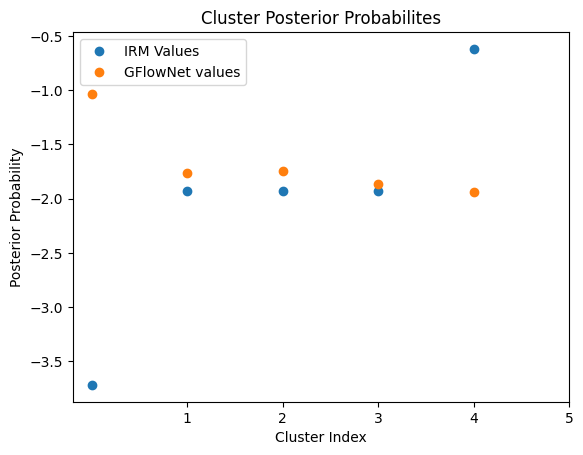

(array([-0.61788491, -1.92721776, -1.92721776, -1.92721776, -3.71897725]),
 tensor([-1.0359, -1.7618, -1.7452, -1.8683, -1.9354], grad_fn=<CopySlices>))

In [21]:
net.plot_full_distribution(adjacency_matrix=A_random)

In [22]:
X = net.sample_forward(adjacency_matrix=A_random)
net.train(X, epochs=100)

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


100%|██████████| 3/3 [00:00<00:00, 17.63it/s]


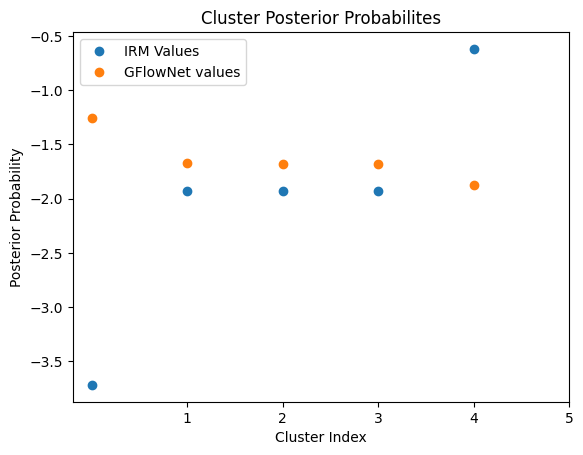

(array([-0.61788491, -1.92721776, -1.92721776, -1.92721776, -3.71897725]),
 tensor([-1.2513, -1.6730, -1.6763, -1.6822, -1.8764], grad_fn=<CopySlices>))

In [18]:
net.plot_full_distribution(adjacency_matrix=A_random)

100%|██████████| 3/3 [00:00<00:00, 20.17it/s]


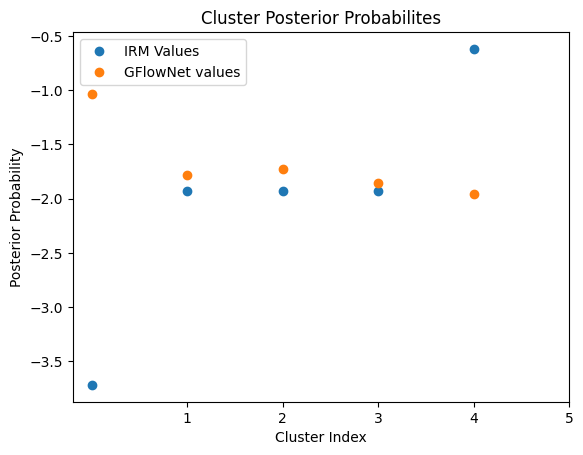

(array([-0.61788491, -1.92721776, -1.92721776, -1.92721776, -3.71897725]),
 tensor([-1.0321, -1.7852, -1.7224, -1.8569, -1.9577], grad_fn=<CopySlices>))

In [23]:
net.plot_full_distribution(adjacency_matrix=A_random)

In [24]:
net.sample_forward(adjacency_matrix)

100%|██████████| 100/100 [00:01<00:00, 88.94it/s]


tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.]])